# Data Challenge: Part I

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
raw_df = pd.read_json('logins.json').set_index('login_time').sort_index()
print(raw_df.index.dtype)
print(raw_df.head(10))

datetime64[ns]
Empty DataFrame
Columns: []
Index: [1970-01-01 20:12:16, 1970-01-01 20:13:18, 1970-01-01 20:16:10, 1970-01-01 20:16:36, 1970-01-01 20:16:37, 1970-01-01 20:21:41, 1970-01-01 20:26:05, 1970-01-01 20:26:21, 1970-01-01 20:31:03, 1970-01-01 20:34:46]


So far so good. pandas has parsed the strings in the json into datetime. We don't need to much more on datetime formatting. Let's check for NaNs just in case:

In [12]:
raw_df.index.isna().sum()

0

We have an empty dataframe so let's create a dummy column to aggregate on after downsampling. Then we'll resample for every 15 min and count aggregate.

In [13]:
# just setting a dummy column for the agg after resampling
raw_df['dummy'] = 1
# resample and count aggregate
counts_per15min = raw_df.resample('15T').agg('count').rename(columns = {'dummy': 'login_counts'})
counts_per15min.head()

,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Based on the sorted header of the index on the first 10 logins this aggregation looks fine.

Text(0.5, 1.0, 'Number of logins per 15 minutes at location')

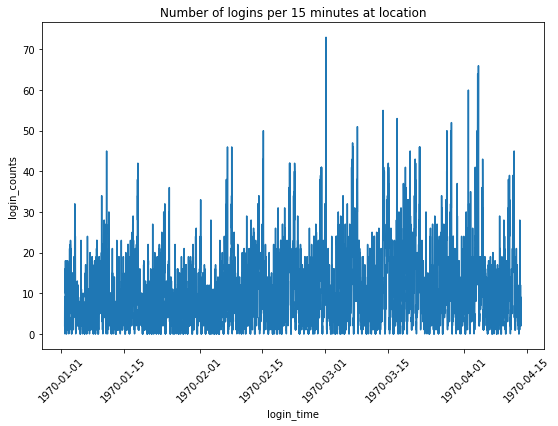

In [85]:
fig, ax = plt.subplots(figsize=(9,6))
sns.lineplot(x = 'login_time', y = 'login_counts', data = counts_per15min, ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Number of logins per 15 minutes at location')


There are multiple levels of cyclicality here. Let's try and get a handle on some of it. First thing's first though it might be good to take a look at the time series over a few intervals.

Text(0.5, 1.0, 'Quarterly hour login tallies for week of 3/1/1970')

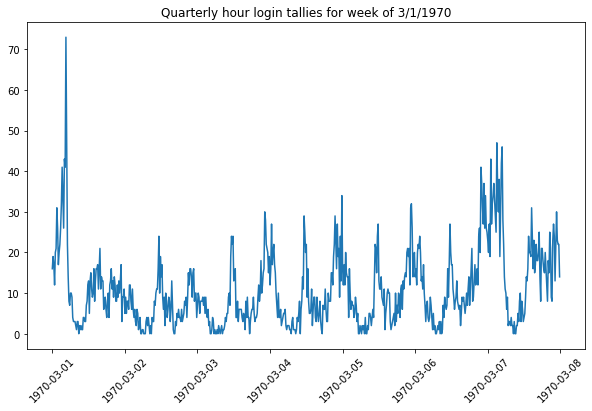

In [95]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(counts_per15min['1970-03-01 00:00':'1970-03-07 23:59'])

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Quarterly hour login tallies for week of 3/1/1970')

This is a fairly representative slice of the time series for a week. There's pretty clearly cyclicality at half-day and full-day periods. But let'z zoom in at 3/5-3/6 just to see what times these peaks in login activity occur.

Text(0.5, 1.0, 'Quarterly hour login tallies 3/5/1970')

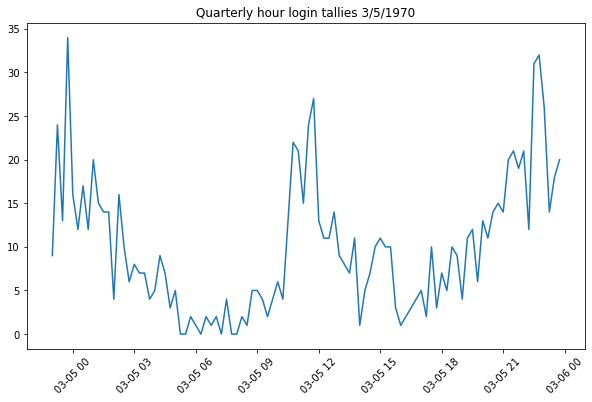

In [97]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(counts_per15min['1970-03-04 23:00':'1970-03-05 23:59'])

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Quarterly hour login tallies 3/5/1970')

The highest login activity pretty much occurs just before midnight, then just before noon, and then again right before midnight. OK this is nice to get a feel for things but we want a more robust measure of daily activity.

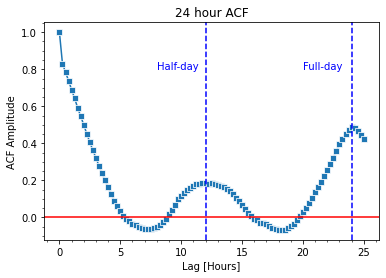

In [188]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
# want to calculate # of data points in a day. At 15 min intervals: 25*4 points in a day. Choose 25 so we can see max in acf at 24 hours
N_day = 25*4
# get the autocorrelation function up to a full day's lag
daily_acf = acf(counts_per15min['login_counts'], nlags = N_day, fft = True)
hour_array = np.arange(0, 25.25, 0.25)

fig, ax = plt.subplots()
sns.lineplot(x = hour_array, y = daily_acf, marker = 's', ax = ax)
ax.set_ylabel('ACF Amplitude')
ax.set_xlabel('Lag [Hours]')
ax.set_title('24 hour ACF')
plt.minorticks_on()
plt.axhline(y = 0, c= 'r')
plt.axvline(x = 12, c = 'b', linestyle = '--')
plt.axvline(x = 24, c = 'b', linestyle = '--')
plt.annotate('Half-day', xy = (8, 0.8),  c ='b')
plt.annotate('Full-day', xy = (20, 0.8),  c ='b')
plt.show()

OK it's pretty clear that there are peaks in the ACF at half day and full day. And from our individual time series plot on a given day it looks like its right before noon and right before midnight. Now let's look at longer term correlations. For starters lets restrict to a month to evaluate whether there is anything interesting going on there.

Text(0.5, 1.0, 'Quarterly hour login tallies for week of 3/1/1970')

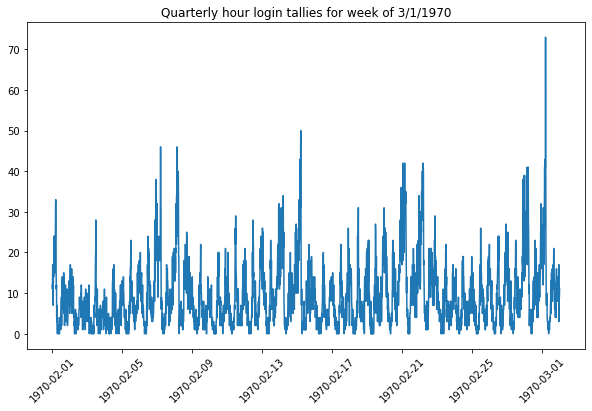

In [191]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(counts_per15min['1970-02-01 00:00':'1970-03-01 23:59'])

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Quarterly hour login tallies for week of 3/1/1970')

It seems that there is weekly activity -- typically at the beginning of the week. But let's see be more systematic about plot the frequency spectrum. We'll scale it all to plot in frequency units of 1/day. 

In [221]:
from scipy.signal import periodogram
f, p = periodogram(counts_per15min['login_counts'])

freq_scale_factor = (24*60)/(15) # this converts the frequency scale to inverse day from (15 min)^-1
f_dayinv = f*freq_scale_factor

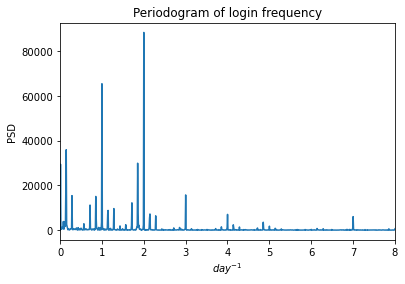

In [231]:
plt.plot(f_dayinv,p)
plt.xlim(0,8)
plt.xlabel('$day^{-1}$')
plt.ylabel('PSD')
plt.title('Periodogram of login frequency')
plt.show()

Well...there are peaks at daily and twice a day. We saw that before in the restricted ACF and direct plots. There are also integer harmonics with varying amplitudes which makes sense: these cyclic variations are not sinusoidal. The interesting thing is the side-band modulation and the lowest frequency major peak (i.e. longest time scale feature).

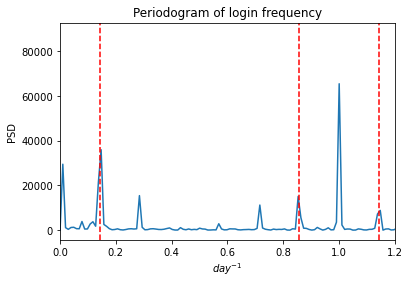

In [241]:
plt.plot(f_dayinv,p)
plt.xlim(0,1.2)
plt.xlabel('$day^{-1}$')
plt.ylabel('PSD')
# x = 1/7 is weekly
plt.axvline(x = 1/7, c ='r', linestyle = '--')
# we also look at 1/7 about the peak at events occuring once a day
plt.axvline(x = 1 - 1/7, c ='r', linestyle = '--')
plt.axvline(x = 1 + 1/7, c ='r', linestyle = '--')

plt.title('Periodogram of login frequency')
plt.show()

OK it's pretty clear what the origin of the sidebands are now. We have a strong weekly component (peak at 1/7 day^-1). The daily and twice-a-day peaks are amplitude modulated by this weekly cadence which shows up as the equally spaced sidebands about the peaks at 1 day^-1 and 2 day^-1 (and integer multiple harmonics thereof). This all makes sense. There's not enough data to start seriously thinking about monthly cyclicality so we'll just leave the whole matter there.

# Final Answer

There are multiple cyclical phenomena in the login data. There is clearly a daily cyclicality as well as a cadence on top of that twice a day. That is: logins increase close to midnight and then close to noon in a daily pattern. But we have also shown that there is a weekly cadence that modulates the daily cycles.